![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/22.2_Retrieval_Augmented_Generation_with_Spark_NLP.ipynb)

# **Retrieval Augmented Generation with Spark NLP**

## **🎬 Colab Setup**

In [1]:
from getpass import getpass
OPENAI_API_KEY = getpass('Please enter your open_api_key:')
# If you do not have an OpenAI key, you can skip the OpenAI section below and continue using open-source LLMs.

Please enter your open_api_key:··········


In [2]:
!pip install -q johnsnowlabs
#!pip install -q pyspark==3.4.1 spark-nlp
!pip install -q langchain openai tiktoken faiss-cpu
!pip install -q ctransformers


In [3]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp.start(params=params, gpu=True)

print("Spark NLP Version :", sparknlp.version())

spark

Spark NLP Version : 5.3.1


# RAG Architecture
A typical RAG application has two main components:

**Indexing**: a pipeline for ingesting data from a source and indexing it. This usually happens offline.
- `Load`: First we need to load our data. This is done with DocumentLoaders.
- `Split`: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won’t fit in a model’s finite context window.
- `Store`: We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.

**Retrieval and generation**: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.
[source](https://python.langchain.com/docs/use_cases/question_answering/)


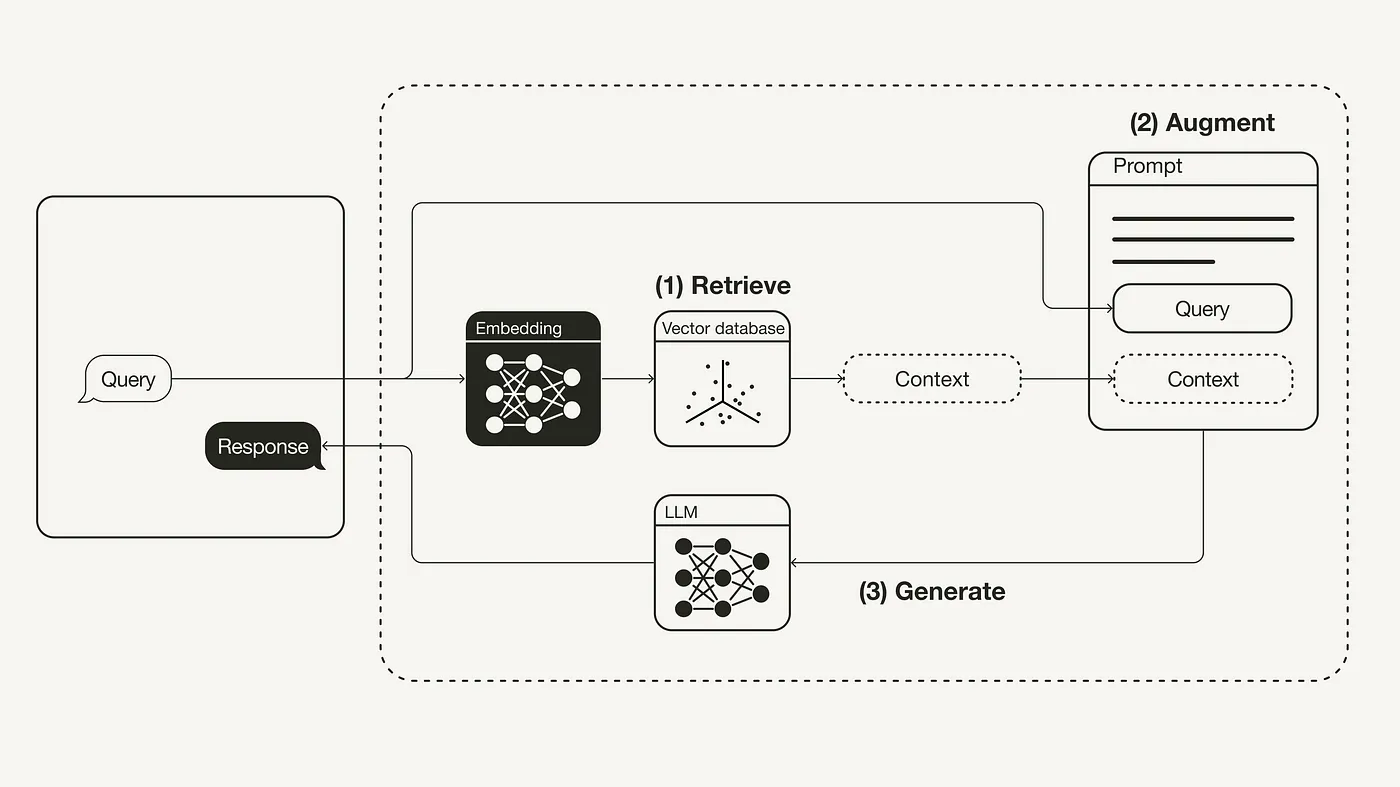

[image source](https://towardsdatascience.com/retrieval-augmented-generation-rag-from-theory-to-langchain-implementation-4e9bd5f6a4f2)

## Dataset

In [4]:
! wget -q https://github.com/JohnSnowLabs/spark-nlp-workshop/raw/master/healthcare-nlp/data/diabetes_txt_files.zip

In [5]:
import shutil

filename = "./diabetes_txt_files.zip"
extract_dir = "./"
archive_format = "zip"

shutil.unpack_archive(filename, extract_dir, archive_format)

In [6]:
multi_doc = spark.read.text("./diabetes_txt_files", wholetext=True).toDF("text")
multi_doc = multi_doc.withColumn("filename", F.input_file_name())\
                      .withColumn("filename",F.split('filename', '/'))\
                      .withColumn('filename', F.col('filename')[F.size('filename') -1])
multi_doc.show(10, truncate=100)

print("document count:", multi_doc.count())

+----------------------------------------------------------------------------------------------------+-----------------------+
|                                                                                                text|               filename|
+----------------------------------------------------------------------------------------------------+-----------------------+
|Diabetes mellitus is a group of diseases associated with various metabolic disorders, the main fe...|PMC4020724_abstract.txt|
|Objective: The peer interaction–based online model has been influential in the recent development...|PMC7432193_abstract.txt|
|Gestational diabetes mellitus (GDM) is associated with developing type 2 diabetes, but very few s...|PMC5770032_abstract.txt|
|A diagnosis of diabetes or hyperglycemia should be confirmed prior to ordering, dispensing, or ad...|PMC6104264_abstract.txt|
|The aim of this study was to describe the characteristics and outcomes of pregnancies in a nation...|PMC705437

## Documet Splitting


In [7]:
def DocumetSplitter(spark_df,input_col = "text", chunk_size= 100,  chunk_overlap = 10):
    from sparknlp.annotator import DocumentAssembler, DocumentCharacterTextSplitter
    from pyspark.ml import Pipeline

    document_assembler = DocumentAssembler()\
        .setInputCol(input_col)\
        .setOutputCol("document")

    character_text_splitter = DocumentCharacterTextSplitter() \
        .setInputCols(["document"]) \
        .setOutputCol("splits") \
        .setChunkSize(chunk_size) \
        .setChunkOverlap(chunk_overlap) \
        .setExplodeSplits(True)\
        .setSplitPatterns(["\n\n", "\n", " "])

    pipeline = Pipeline().setStages([
            document_assembler,
            character_text_splitter
    ])

    result_df = pipeline.fit(spark_df).transform(spark_df)

    splitted_pd_df = result_df.selectExpr("splits.result[0] as splits",
                                          "splits.metadata[0].document as splits_id",
                                          "filename as document_id",).toPandas()

    return splitted_pd_df

In [42]:
splitted_pd_df = DocumetSplitter(multi_doc.limit(100),
                                 chunk_size = 1000,
                                 chunk_overlap = 50)
splitted_pd_df

,splits,splits_id,document_id
0,Diabetes mellitus is a group of diseases assoc...,0,PMC4020724_abstract.txt
1,A scheme of the relationship between etiology...,1,PMC4020724_abstract.txt
2,The classification of glucose metabolism disor...,2,PMC4020724_abstract.txt
3,on the degree of hyperglycemia occurring as a ...,3,PMC4020724_abstract.txt
4,*Casual plasma glucose ≥200 mg/dL (≥11.1 mmol/...,4,PMC4020724_abstract.txt
...,...,...,...
386,"In 1992, 1,091 individuals were interviewed an...",1,PMC6944834_abstract.txt
387,These results suggest that particular efforts ...,2,PMC6944834_abstract.txt
388,To systematically review the risk factors for ...,0,PMC7779280_abstract.txt
389,A total of 24 case–control studies were includ...,1,PMC7779280_abstract.txt


In [43]:
def LoadDocument(splitted_pd_df, page_content_column="splits"):
  # from langchain.document_loaders import PySparkDataFrameLoader
  # loader = PySparkDataFrameLoader(spark, splitted_df,
  #                                 page_content_column = page_content_column)
  # splitted_docs = loader.load()

  from langchain.document_loaders import DataFrameLoader
  loader = DataFrameLoader(splitted_pd_df,
                           page_content_column)
  splitted_docs = loader.load()

  return splitted_docs

In [44]:
splitted_docs = LoadDocument(splitted_pd_df, page_content_column="splits")
splitted_docs

[Document(page_content='Diabetes mellitus is a group of diseases associated with various metabolic disorders, the main feature of which is chronic hyperglycemia due to insufficient insulin action. Its pathogenesis involves both genetic and environmental factors. The long‐term persistence of metabolic disorders can cause susceptibility to specific complications and also foster arteriosclerosis. Diabetes mellitus is associated with a broad range of clinical presentations, from being asymptomatic to ketoacidosis or coma, depending on the degree of metabolic disorder.\nNote: Those that cannot at present be classified as any of the above are called unclassifiable.\nThe occurrence of diabetes‐specific complications has not been confirmed in some of these conditions.\nThe occurrence of diabetes‐specific complications has not been confirmed in some of these conditions.', metadata={'splits_id': '0', 'document_id': 'PMC4020724_abstract.txt'}),
 Document(page_content='\u2002A scheme of the relati

In [45]:
splitted_docs[:2]

[Document(page_content='Diabetes mellitus is a group of diseases associated with various metabolic disorders, the main feature of which is chronic hyperglycemia due to insufficient insulin action. Its pathogenesis involves both genetic and environmental factors. The long‐term persistence of metabolic disorders can cause susceptibility to specific complications and also foster arteriosclerosis. Diabetes mellitus is associated with a broad range of clinical presentations, from being asymptomatic to ketoacidosis or coma, depending on the degree of metabolic disorder.\nNote: Those that cannot at present be classified as any of the above are called unclassifiable.\nThe occurrence of diabetes‐specific complications has not been confirmed in some of these conditions.\nThe occurrence of diabetes‐specific complications has not been confirmed in some of these conditions.', metadata={'splits_id': '0', 'document_id': 'PMC4020724_abstract.txt'}),
 Document(page_content='\u2002A scheme of the relati

## JohnSnowLabsLangChainEmbedder

In [46]:
from johnsnowlabs.llm import embedding_retrieval

embeddings =  embedding_retrieval.JohnSnowLabsLangChainEmbedder('en.embed_sentence.instructor_base',
                                                                hardware_target="gpu")

Spark Session already created, some configs may not take.
instructor_base download started this may take some time.
Approximate size to download 387.7 MB
[OK!]


In [47]:
# embeddings.embed_query('test for something')

## Vector Databases

In [48]:
%%time
from langchain.vectorstores import FAISS

db = FAISS.from_documents(splitted_docs, embeddings)
faiss_retriever = db.as_retriever(search_kwargs={"k": 3})
#!zip -r faiss_retriever.zip faiss_retriever

CPU times: user 244 ms, sys: 30.2 ms, total: 274 ms
Wall time: 23.9 s


In [49]:
relevavant_docs = faiss_retriever.get_relevant_documents("causes of diabetes")
len(relevavant_docs)

3

In [50]:
relevavant_docs

[Document(page_content='Diabetic patients, during the course of the disease, are most likely to experience depressive symptoms that might ultimately lead to suicidal ideation or suicide. The size of literature in diabetes depression/suicide is a good indicator of national and international efforts to address psychological co-morbidities associated with diabetes mellitus (DM). Therefore, the objective of this study was to give a comprehensive analysis, both quantitative and qualitative, of scientific literature in diabetes depression/suicide.\nSciVerse Scopus was used to retrieve relevant literature up to 2016.', metadata={'splits_id': '0', 'document_id': 'PMC6198430_abstract.txt'}),
 Document(page_content='Background: Diabetes mellitus (DM) is a common chronic disorder in children and is caused by absolute or relative insulin deficiency, with or without insulin resistance. There are several different forms of childhood DM. Children can suffer from neonatal diabetes mellitus (NDM), type

## OpenAI

In [51]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

# completion llm
llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-3.5-turbo-16k',
    temperature=0.0
)


In [52]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=faiss_retriever,
    return_source_documents=True
    )

question = "causes for diabetes?"
result = qa_chain({"query": question})

print (result['result'])

The causes of diabetes can vary depending on the type of diabetes. 

Type 1 diabetes is believed to be caused by an autoimmune reaction in which the body's immune system mistakenly attacks and destroys the insulin-producing cells in the pancreas. The exact cause of this autoimmune reaction is not known, but it is thought to involve a combination of genetic and environmental factors.

Type 2 diabetes is primarily caused by a combination of genetic and lifestyle factors. It is often associated with obesity, physical inactivity, and poor diet. Genetic factors can also play a role in determining a person's risk of developing type 2 diabetes.

Other forms of diabetes, such as gestational diabetes and certain types of monogenic diabetes, have their own specific causes and risk factors.

It's important to note that while certain factors can increase the risk of developing diabetes, it does not mean that everyone with these risk factors will develop the disease. Additionally, there may be othe

### PromptTemplate

In [53]:
qa_chain.combine_documents_chain.llm_chain.prompt.messages[0].prompt.template


"Use the following pieces of context to answer the user's question. \nIf you don't know the answer, just say that you don't know, don't try to make up an answer.\n----------------\n{context}"

In [54]:
from langchain.prompts import PromptTemplate

new_template = """
Use the following pieces of context to answer the user's question. If you return an answer, end with 'It's my pleasure'.
If you don't know the answer, just say that you don't know, don't try to make up an answer .
{context}
Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(new_template)

In [55]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=faiss_retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "causes for diabetes?"
result = qa_chain({"query": question})

print(result['result'])

The causes of diabetes can vary depending on the type of diabetes. Type 1 diabetes is believed to be caused by an autoimmune reaction where the body's immune system mistakenly attacks and destroys the insulin-producing cells in the pancreas. The exact cause of type 2 diabetes is not fully understood, but it is thought to involve a combination of genetic and lifestyle factors, such as obesity and lack of physical activity. It's my pleasure to help!


In [56]:
pd.DataFrame([doc.metadata for doc in result['source_documents']])

,splits_id,document_id
0,0,PMC6198430_abstract.txt
1,0,PMC6882272_abstract.txt
2,0,PMC7054376_abstract.txt


In [57]:
relevavant_docs

[Document(page_content='Diabetic patients, during the course of the disease, are most likely to experience depressive symptoms that might ultimately lead to suicidal ideation or suicide. The size of literature in diabetes depression/suicide is a good indicator of national and international efforts to address psychological co-morbidities associated with diabetes mellitus (DM). Therefore, the objective of this study was to give a comprehensive analysis, both quantitative and qualitative, of scientific literature in diabetes depression/suicide.\nSciVerse Scopus was used to retrieve relevant literature up to 2016.', metadata={'splits_id': '0', 'document_id': 'PMC6198430_abstract.txt'}),
 Document(page_content='Background: Diabetes mellitus (DM) is a common chronic disorder in children and is caused by absolute or relative insulin deficiency, with or without insulin resistance. There are several different forms of childhood DM. Children can suffer from neonatal diabetes mellitus (NDM), type

In [58]:
# Retrieve more documents with higher diversity
# Useful if your dataset has many similar documents

#lambda_mult – Number between 0 and 1 that determines the degree of diversity among the results with 0 corresponding to maximum diversity and 1 to minimum diversity. Defaults to 0.5.

faiss_retriever_ = db.as_retriever(search_type="mmr",
    search_kwargs={'k': 6,
                   'lambda_mult': 0.25})

faiss_retriever_.get_relevant_documents("causes of diabetes")[:3]

[Document(page_content='Diabetic patients, during the course of the disease, are most likely to experience depressive symptoms that might ultimately lead to suicidal ideation or suicide. The size of literature in diabetes depression/suicide is a good indicator of national and international efforts to address psychological co-morbidities associated with diabetes mellitus (DM). Therefore, the objective of this study was to give a comprehensive analysis, both quantitative and qualitative, of scientific literature in diabetes depression/suicide.\nSciVerse Scopus was used to retrieve relevant literature up to 2016.', metadata={'splits_id': '0', 'document_id': 'PMC6198430_abstract.txt'}),
 Document(page_content='with SMBG three or more times daily and diabetes duration of 1 to <5\xa0years.', metadata={'splits_id': '2', 'document_id': 'PMC8015826_abstract.txt'}),
 Document(page_content='Gestational diabetes insipidus (DI) is a rare complication of pregnancy, usually developing in the third tr

In [59]:
# Fetch more documents for the MMR algorithm to consider
# But only return the top 5
# fetch_k – Number of Documents to fetch before filtering to pass to MMR algorithm.

faiss_retriever_ = db.as_retriever(
    search_type="mmr",
    search_kwargs={'k': 5, 'fetch_k': 50}
)

faiss_retriever_.get_relevant_documents("causes of diabetes")[:3]

[Document(page_content='Diabetic patients, during the course of the disease, are most likely to experience depressive symptoms that might ultimately lead to suicidal ideation or suicide. The size of literature in diabetes depression/suicide is a good indicator of national and international efforts to address psychological co-morbidities associated with diabetes mellitus (DM). Therefore, the objective of this study was to give a comprehensive analysis, both quantitative and qualitative, of scientific literature in diabetes depression/suicide.\nSciVerse Scopus was used to retrieve relevant literature up to 2016.', metadata={'splits_id': '0', 'document_id': 'PMC6198430_abstract.txt'}),
 Document(page_content='with SMBG three or more times daily and diabetes duration of 1 to <5\xa0years.', metadata={'splits_id': '2', 'document_id': 'PMC8015826_abstract.txt'}),
 Document(page_content='Gestational diabetes insipidus (DI) is a rare complication of pregnancy, usually developing in the third tr

In [60]:
search_type="similarity_score_threshold",

In [61]:
question = "relationship between diabetes and obesity"

qa_chain({"query": question})['result']

"The context provided suggests that there is a relationship between diabetes and obesity. The prevalence of Type 2 diabetes mellitus and obesity has increased over time, and there is a significant association between BMI increase and Type 2 diabetes mellitus prevalence. Additionally, the study mentioned in the context aims to analyze the literature on diabetes depression/suicide, indicating that psychological co-morbidities are associated with diabetes mellitus. Therefore, it can be inferred that there is a relationship between diabetes and obesity, with obesity being a risk factor for the development of Type 2 diabetes mellitus. It's my pleasure to help!"

In [62]:
question = "childhood diabetes and mortality"

qa_chain({"query": question})['result']

"Based on the provided context, the information does not directly address the mortality rates of childhood diabetes. Therefore, it is unclear what the specific relationship is between childhood diabetes and mortality. It's my pleasure to assist you."

## Zephyr

In [ ]:
from langchain.llms import CTransformers
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = CTransformers(model="TheBloke/zephyr-7B-beta-GGUF",
                    model_file = 'zephyr-7b-beta.Q4_0.gguf',
                    model_type="mistral",
                    temperature = 0.01,
                    max_new_tokens = 250,
                    context_length = 500,
                    lib="avx2", #for CPU use
                    callbacks=[StreamingStdOutCallbackHandler()])

In [81]:
db = FAISS.from_documents(splitted_docs, embeddings)
faiss_retriever = db.as_retriever(search_kwargs={"k": 1})

In [82]:
qa_chain_faiss = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=faiss_retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [85]:
question = "relationship between diabetes and obesity"

qa_result = qa_chain_faiss({"query": question})['result']

 Yes, there is a strong relationship between diabetes and obesity. Over the past several decades, both the prevalence of diabetes and obesity have increased rapidly, and studies have consistently shown that obesity is a major risk factor for developing diabetes. In fact, it's estimated that up to 90% of people with type 2 diabetes are overweight or obese. This suggests that addressing obesity through lifestyle changes such as diet and exercise may be an effective way to prevent and manage diabetes.

In [75]:
faiss_retriever.get_relevant_documents(question)

[Document(page_content='Over 1978–2013, Type 2 diabetes mellitus prevalence increased from 1.2% to 19.6% in men (2.3% per 5 years), and from 2.2% to 19.5% in women (2.2% per 5 years). Obesity prevalence increased from 27.7% to 53.1% in men (3.6% per 5 years) and from 44.4% to 76.7% (4.5% per 5 years) in women. Type 2 diabetes mellitus and obesity prevalences increased in all age groups. From period trends, Type 2 diabetes mellitus prevalence in 2020 is projected to be 26% in men and women. Projected obesity prevalence is projected to be 59% in men and 81% in women. Type 2 diabetes mellitus period trends attributable to BMI increase are estimated as 31% (men) and 16% (women), after adjusting for age.', metadata={'splits_id': '1', 'document_id': 'PMC5411261_abstract.txt'})]

## Llama-2

Split size (k) cannot be set larger than 2-3 due to the context limit of LLama-2 (max context = 4096) as we join all the splits and send to LLM along with system prompt andf query. That's why we could only set k=3.

In [78]:
from langchain.prompts import PromptTemplate

new_template = """
Use the following pieces of context to answer the user's question. If you return an answer, end with 'It's my pleasure'.
If you don't know the answer, just say that you don't know, don't try to make up an answer .
{context}
Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(new_template)


from langchain.llms import CTransformers
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = CTransformers(model="TheBloke/Llama-2-7B-Chat-GGUF",
                    model_file = 'llama-2-7b-chat.Q4_0.gguf',
                    model_type="llama",
                    config={'temperature': 0.01,
                            'max_new_tokens': 512,
                            'context_length': 500
                            },
                    callbacks=[StreamingStdOutCallbackHandler()]
                    )

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [79]:

from langchain.chains import RetrievalQA

qa_chain_faiss = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=faiss_retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "relationship between diabetes and obesity"

qa_chain_faiss({"query": question})['result']

 It's my pleasure to help you with that! According to the given data, there is a strong positive correlation between diabetes and obesity. The prevalence of Type 2 diabetes mellitus increases significantly with increasing obesity prevalence in both men and women. In fact, based on the period trends, it's projected that by 2020, the prevalence of Type 2 diabetes mellitus will be 26% in both men and women, and the obesity prevalence is projected to be 59% in men and 81% in women. This suggests a strong association between obesity and

 an

" It's my pleasure to help you with that! According to the given data, there is a strong positive correlation between diabetes and obesity. The prevalence of Type 2 diabetes mellitus increases significantly with increasing obesity prevalence in both men and women. In fact, based on the period trends, it's projected that by 2020, the prevalence of Type 2 diabetes mellitus will be 26% in both men and women, and the obesity prevalence is projected to be 59% in men and 81% in women. This suggests a strong association between obesity and an"

In [86]:
faiss_retriever.get_relevant_documents(question)

[Document(page_content='Over 1978–2013, Type 2 diabetes mellitus prevalence increased from 1.2% to 19.6% in men (2.3% per 5 years), and from 2.2% to 19.5% in women (2.2% per 5 years). Obesity prevalence increased from 27.7% to 53.1% in men (3.6% per 5 years) and from 44.4% to 76.7% (4.5% per 5 years) in women. Type 2 diabetes mellitus and obesity prevalences increased in all age groups. From period trends, Type 2 diabetes mellitus prevalence in 2020 is projected to be 26% in men and women. Projected obesity prevalence is projected to be 59% in men and 81% in women. Type 2 diabetes mellitus period trends attributable to BMI increase are estimated as 31% (men) and 16% (women), after adjusting for age.', metadata={'splits_id': '1', 'document_id': 'PMC5411261_abstract.txt'})]